In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from math import pi
import warnings
# 忽略 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

D:\Soft\code_soft\anaconda\envs\rgis9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 定义函数

In [2]:
def calculate_error(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return U95
    return {
        "R": round(R, 3),
        "%RMSE": RMSE_percent,
        # "RMSE": round(RMSE, 3),
        "%MBE": MBE_percent,
        # "MBE": round(MBE, 3),
        "U95": round(U95, 3)
    }

### 13-1DEM和坡度的双轴折线图

In [68]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2", "ISCCP-ITP":"ISCCP"})
station_data = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "DEM_level", "Slope_level"]]
# 添加土地覆盖类型字段
database = pd.merge(database, station_data, on="originalID", how="left" )
# drop没用的字段
database = database.drop(columns=["originalID", "stationIndex", "date", "lat", "lon"])
# 数据产品列名
products = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

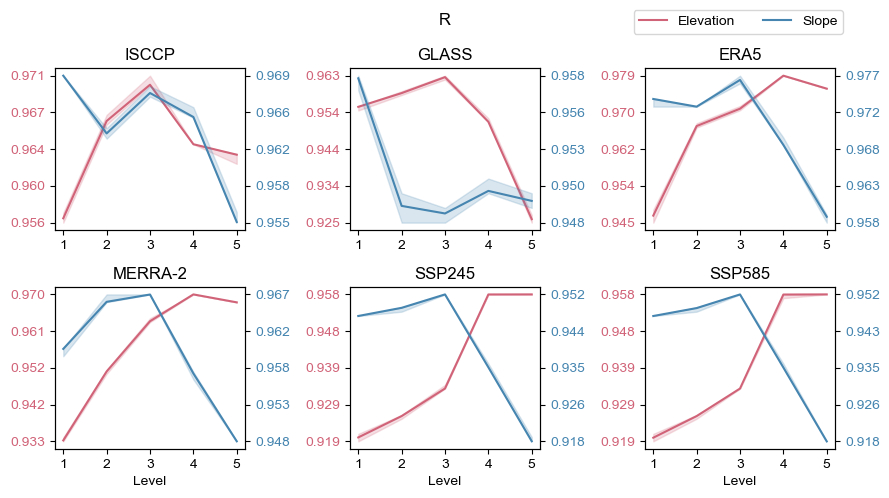

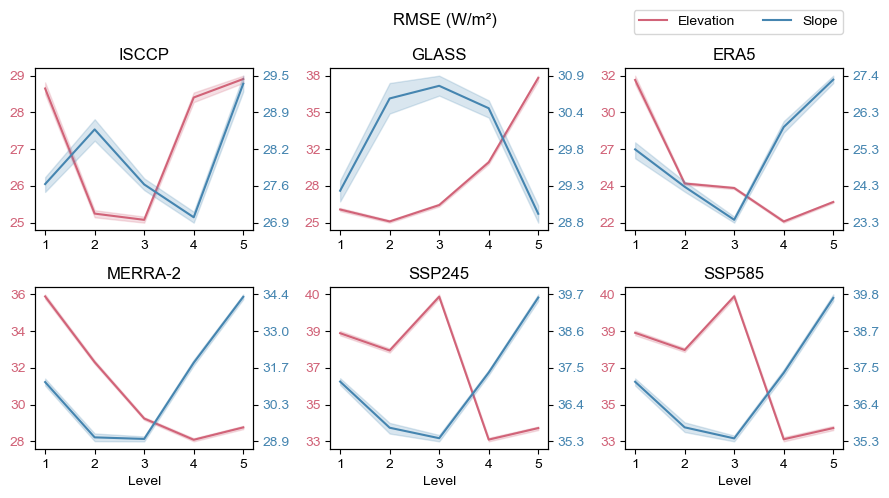

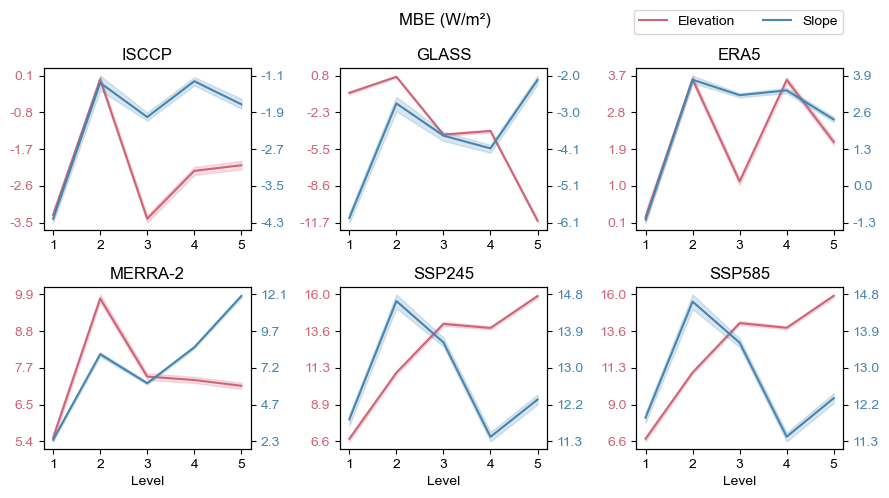

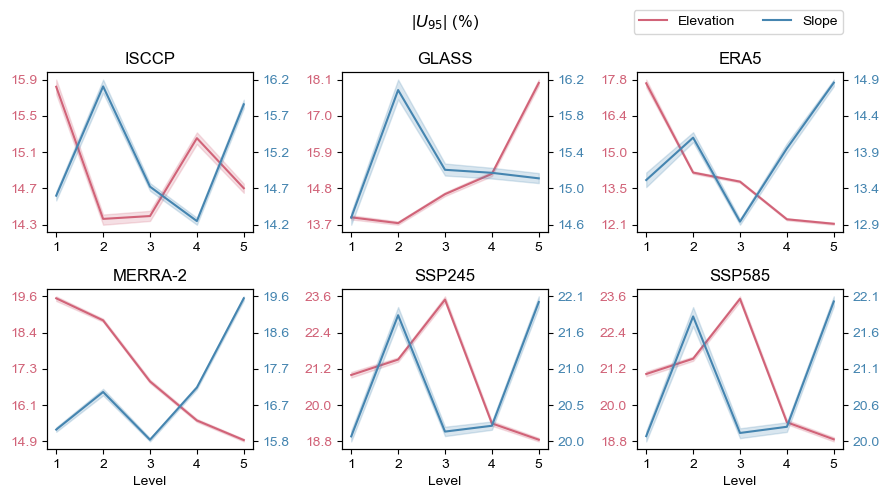

In [69]:
# 等级列表
levels = [1, 2, 3, 4, 5]

# 误差指标列表
error_metrics = ['R', 'RMSE', 'MBE', 'U95']
# error_metrics = ['R']

# 自助法抽样次数
n_bootstraps = 200

# 为每个误差指标绘制一组 2X3 的双轴折线图
for metric in error_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(9, 5))
    handles = []
    labels = []
    for i, product in enumerate(products):
        # 计算不同高程等级下的误差及置信区间
        dem_errors = []
        dem_lower_ci = []
        dem_upper_ci = []
        for level in levels:
            subset = database[database['DEM_level'] == level]
            subset_filter = subset[~subset[product].isna()][["Observation", product]].reset_index(drop=True)
            if len(subset_filter) == 0:
                dem_errors.append(np.nan)
                dem_lower_ci.append(np.nan)
                dem_upper_ci.append(np.nan)
                continue
            bootstrapped_errors = []
            for _ in range(n_bootstraps):
                sample = subset_filter.sample(frac=1, replace=True)
                error_dict = calculate_error(sample['Observation'], sample[product])
                bootstrapped_errors.append(error_dict[metric])
            dem_errors.append(np.mean(bootstrapped_errors))
            dem_lower_ci.append(np.percentile(bootstrapped_errors, 2.5))
            dem_upper_ci.append(np.percentile(bootstrapped_errors, 97.5))

        # 计算不同坡度等级下的误差及置信区间
        slope_errors = []
        slope_lower_ci = []
        slope_upper_ci = []
        for level in levels:
            subset = database[database['Slope_level'] == level]
            subset_filter = subset[~subset[product].isna()][["Observation", product]].reset_index(drop=True)
            if len(subset_filter) == 0:
                slope_errors.append(np.nan)
                slope_lower_ci.append(np.nan)
                slope_upper_ci.append(np.nan)
                continue
            bootstrapped_errors = []
            for _ in range(n_bootstraps):
                sample = subset_filter.sample(frac=1, replace=True)
                error_dict = calculate_error(sample['Observation'], sample[product])
                bootstrapped_errors.append(error_dict[metric])
            slope_errors.append(np.mean(bootstrapped_errors))
            slope_lower_ci.append(np.percentile(bootstrapped_errors, 2.5))
            slope_upper_ci.append(np.percentile(bootstrapped_errors, 97.5))

        # 确定当前子图的位置
        row = i // 3
        col = i % 3
        ax1 = axes[row, col]

        # 绘制高程误差折线图及置信区间
        color = "#d16378"
        line1 = ax1.plot(levels, dem_errors, color=color)
        ax1.fill_between(levels, dem_lower_ci, dem_upper_ci, color=color, alpha=0.2)
        ax1.tick_params(axis='y', labelcolor=color)

        # 设置高程 Y 轴刻度为 5 个值
        valid_dem_vals = [x for x in dem_errors + dem_lower_ci + dem_upper_ci if not np.isnan(x)]
        if valid_dem_vals:
            y_min = min(valid_dem_vals)
            y_max = max(valid_dem_vals)
            ax1.set_yticks(np.linspace(y_min, y_max, 5))
            # 格式化高程 Y 轴刻度标签
            if metric == "R":
                ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.3f}'))
            elif metric == "RMSE":
                ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
            elif metric in ["MBE", "U95"]:
                ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))


        # 创建第二个 Y 轴
        ax2 = ax1.twinx()

        # 绘制坡度误差折线图及置信区间
        color = '#4585b0'
        line2 = ax2.plot(levels, slope_errors, color=color)
        ax2.fill_between(levels, slope_lower_ci, slope_upper_ci, color=color, alpha=0.2)
        ax2.tick_params(axis='y', labelcolor=color)

        # 设置坡度 Y 轴刻度为 5 个值
        valid_slope_vals = [x for x in slope_errors + slope_lower_ci + slope_upper_ci if not np.isnan(x)]
        if valid_slope_vals:
            y_min = min(valid_slope_vals)
            y_max = max(valid_slope_vals)
            ax2.set_yticks(np.linspace(y_min, y_max, 5))
            # 格式化高程 Y 轴刻度标签
            if metric == "R":
                ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.3f}'))
            elif metric in ["MBE", "U95", "RMSE"]:
                ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

        # 设置子图标题
        ax1.set_title(f'{product}', fontsize=12)
        # 设置 X 轴刻度和轴刻度标签为 1、2、3、4、5
        ax1.set_xticks(levels)
        ax1.set_xticklabels(levels)

        if row == 1:
            ax1.set_xlabel('Level')
        # 收集线条句柄和标签
        if i == 0:
            handles.extend([line1[0], line2[0]])
            labels.extend(['Elevation', 'Slope'])

    if metric in ["RMSE", "MBE"]:
        metric_unit = f"{metric} (W/m²)"
    elif metric == "U95":
        metric_unit = r"|$U_{95}$| (%)"
    else:
        metric_unit = "R"
    # plt.suptitle(f'{metric_unit}',x=0, y=0.95, ha="left", fontsize=12)
    plt.suptitle(f'{metric_unit}', fontsize=12)
    # 添加图例
    fig.legend(handles, labels, bbox_to_anchor=(0.95, 1), ncol=2) # 坐标(0.95, 1)是相对于图形区域的，(0, 0) 表示左下角，(1, 1) 表示右上角。
    # 调整子图布局
    plt.tight_layout()
    plt.savefig(f'figs/13折线图组2x3-{metric}.png', format='png', dpi=1000, bbox_inches='tight')
    plt.show()

### 13-2坡向的玫瑰图

In [3]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2"})
station_data = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "Aspect"]]
# 添加坡向字段
database = pd.merge(database, station_data, on="originalID", how="left" )
# drop没用的字段
database = database.drop(columns=["originalID", "stationIndex", "date", "lat", "lon"])
# 数据产品列名
# products = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

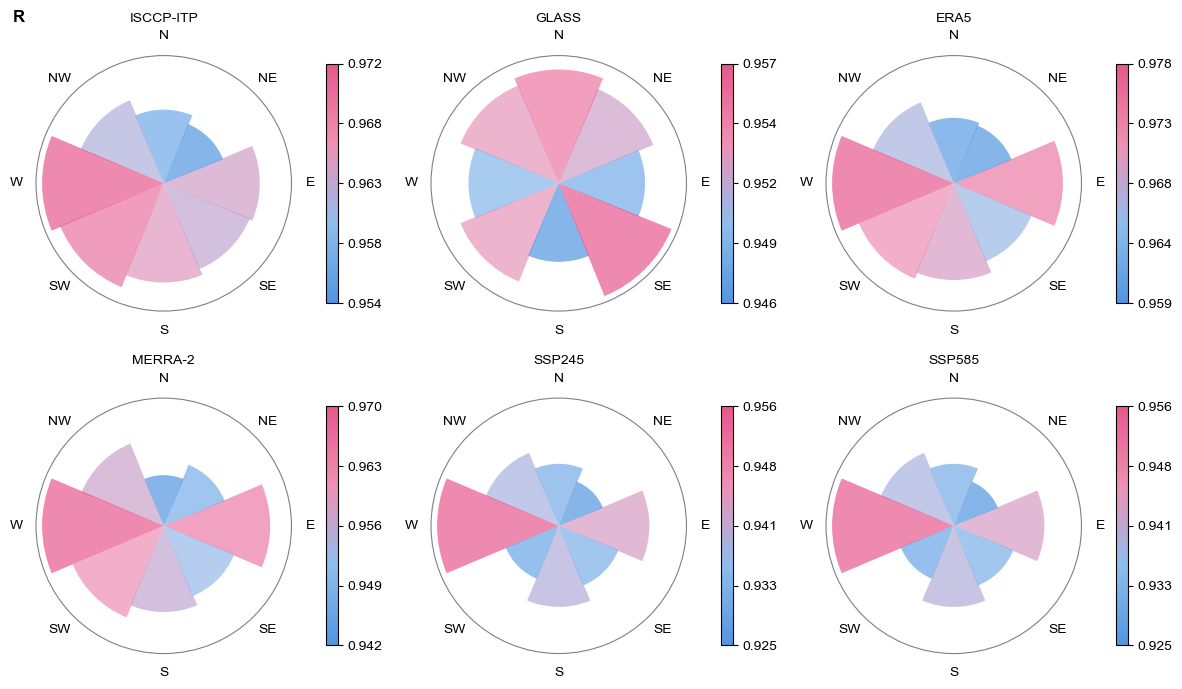

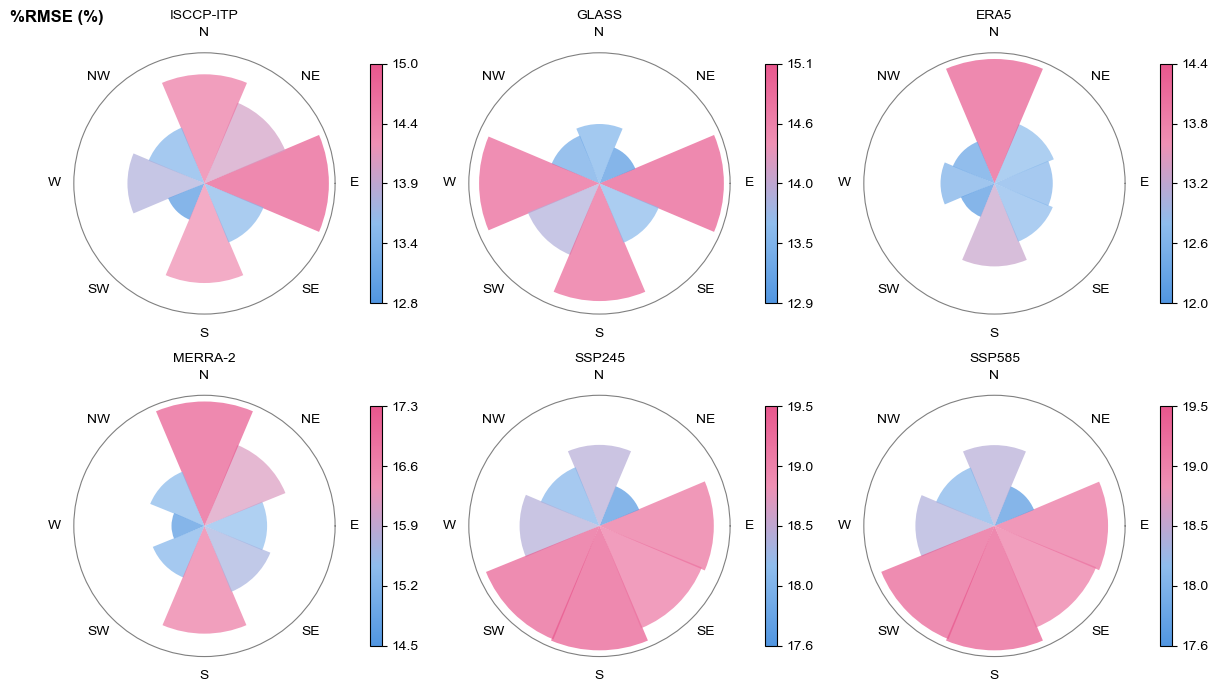

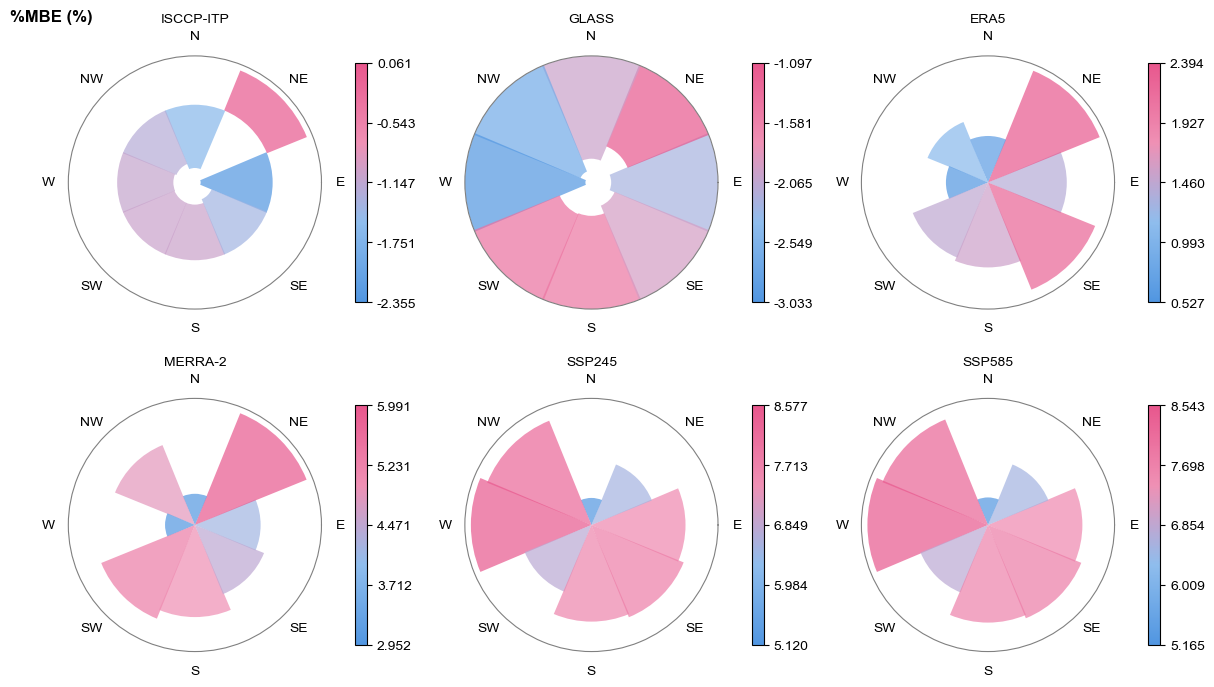

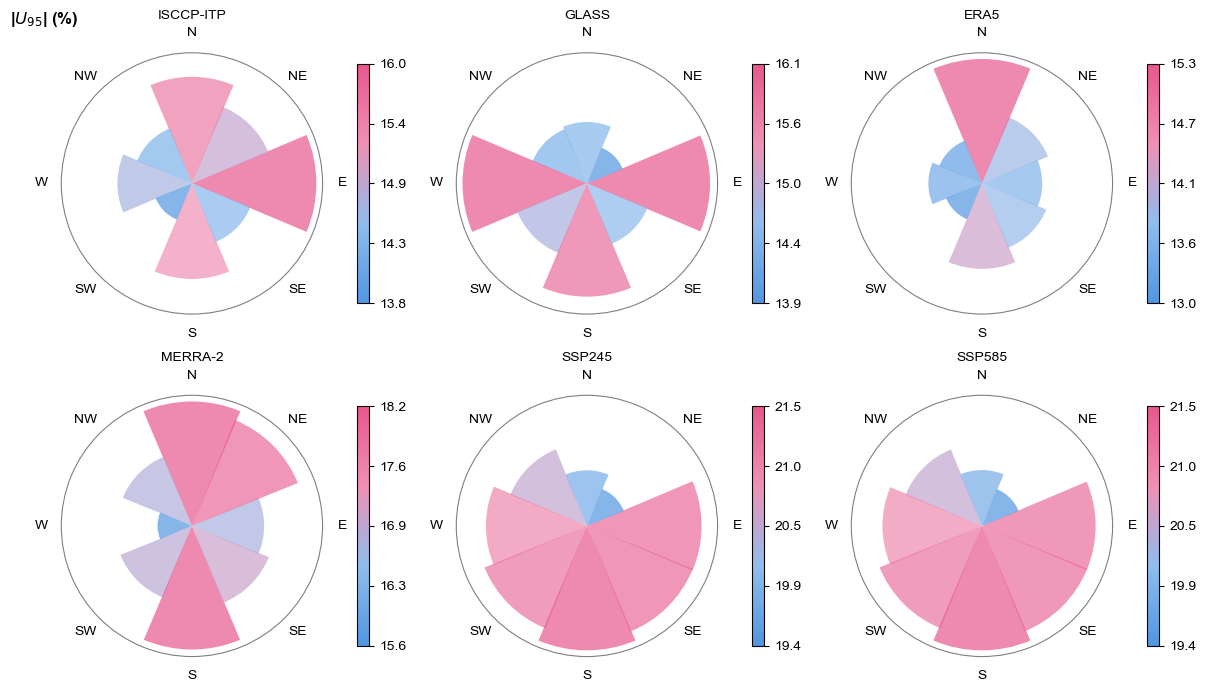

In [4]:
# 计算每个产品的误差（使用循环替代函数）
all_errors = {
    "R": {},
    "%RMSE": {},
    "%MBE": {},
    "U95": {}
}
products = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
directions = ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']

for product in products:
    for direction in directions:
        direction_data = database[database['Aspect'] == direction]
        direction_data_filter = direction_data[~direction_data[product].isna()][["Observation", product]].reset_index(drop=True)
        error = calculate_error(direction_data_filter['Observation'], direction_data_filter[product])
        for metric in all_errors:
            if product not in all_errors[metric]:
                all_errors[metric][product] = []
            all_errors[metric][product].append(error[metric])

# 绘制南丁格尔玫瑰图（带颜色渐变，使用循环替代函数）
direction_angles = {'E': 0, 'NE': 45, 'N': 90, 'NW': 135, 'W': 180, 'SW': 225, 'S': 270, 'SE': 315}
metrics = ["R", "%RMSE", "%MBE", "U95"]

for metric in metrics:
    print(metric)
    errors = all_errors[metric]
    errorsToExcel = pd.DataFrame(errors)
    # errorsToExcel.to_excel(f"./datas/坡向误差_{metric}.xlsx") # 保存实验数据
    print(errors)
    # 创建一个 2x3 的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), subplot_kw=dict(polar=True))

    # 扁平化 axes 数组以便访问
    axes = axes.flatten()

    # 对每个产品绘制南丁格尔玫瑰图
    for i, product in enumerate(errors):
        ax = axes[i]  # 获取当前子图的坐标轴

        # 角度和误差值
        angles = [direction_angles[dir] * (pi / 180) for dir in directions]
        mean_errors = errors[product]
        mean_errors = np.array(mean_errors)
        min_error = min(mean_errors)
        # 将所有为正的元素减去 min_error，所有为负的元素加上 min_error
        if metric == "R":
            mean_errors_adjust = np.where(mean_errors > 0, mean_errors - min_error + 0.02, mean_errors + min_error - 0.02)
        else:
            mean_errors_adjust = np.where(mean_errors > 0, mean_errors - min_error + 1, mean_errors + min_error - 1)

        # 使用颜色渐变（根据误差值设置颜色）
        norm = Normalize(vmin=min(mean_errors), vmax=max(mean_errors))  # 归一化误差值
        # 创建自定义色图
        custom_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", ["#5196e1", "#8fbded", "#ef90b4", "#e8578d"])
        # 计算颜色渐变
        colors = [custom_cmap(norm(error)) for error in mean_errors]

        # 以南丁格尔玫瑰图的形式绘制
        bars = ax.bar(angles, mean_errors_adjust, width=0.8, alpha=0.7, linewidth=1, color=colors)

        # 设置极坐标图的标题和标签
        ax.set_title(f'{product}', size=10)
        ax.set_xticks(angles)
        ax.set_xticklabels(directions, size=10)
        for line in ax.xaxis.get_ticklines():
            line.set_visible(False)

        # 为每个子图添加独立的色带
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])  # 设置空数组，因为我们只需要色带
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, location="right", pad=0.1)
        # 设置色带的标签数目为5个
        cbar.set_ticks(np.linspace(mean_errors.min(), mean_errors.max(), 5))
        if metric in ["R", "%MBE"]:
            cbar.set_ticklabels([f"{tick:.3f}" for tick in np.linspace(mean_errors.min(), mean_errors.max(), 5)])
        elif metric in ["%RMSE", "U95"]:
            cbar.set_ticklabels([f"{tick:.1f}" for tick in np.linspace(mean_errors.min(), mean_errors.max(), 5)])

        # 隐藏轴
        ax.axes.yaxis.set_visible(False)
        ax.grid(False)
        ax.spines['polar'].set_color('gray')  # 设置polar spine的颜色为灰色

    # 调整布局
    plt.tight_layout()
    if metric in ["%RMSE", "%MBE"]:
        metric_unit = f"{metric} (%)"
    elif metric == "U95":
        metric_unit = r"|$U_{95}$| (%)"
    else:
        metric_unit = "R"
    plt.suptitle(f'{metric_unit}', fontsize=12, fontweight="bold", x=0.02, y=0.98)
    # plt.suptitle(f'{metric_unit}', fontsize=12, fontweight="bold")
    plt.savefig(f'figs/13玫瑰图组2x3-{metric}.png', format='png', dpi=1000, bbox_inches='tight')
    plt.show()